In [1]:
from datetime import datetime as dt
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

## Plot PDFs

In [2]:
def K_to_eps(K):
    return 2*np.log((K+1.) / K)

def eps_to_K(eps):
    return max(0, (1./(np.exp(eps/2.) -1)))

def pdf_laplace(eps, g, x):
    b = g / eps
    return (1./(2*b))*np.exp(-1.*np.abs(x)/b)

def pdf_unif(K, g, x, batched=False):
    if x < 0:
        return 0
    if batched and x <= g*(K+1) and x >=g:
        return (1 / (g*K))
    if not batched and x <= g*(K+1):
        return 1/(g*(K+1))
    else:
        return 0

def pdf_staircase(eps, g, x, gamma=None):
    x = np.abs(x)
    if gamma is None:
        gamma = 1/(1+np.exp(eps/2.))
    # NOTE: drop factor of 2 in denom
    alpha = (1-np.exp(-1*eps)) / (g*(gamma + np.exp(-1*eps)*(1-gamma)))
    k = (np.floor((x - gamma*g) / g))
    return np.exp(-1*(k+1)*eps) * alpha

def pdf_exp(eps, g, x):
    l = eps / g
    return l*np.exp(-l*x)

def pdf_geometric(eps, g, x):
    k = np.floor(np.abs(x))
    p =  1. - np.exp(-1*eps/g)
    return p*(1-p)**k

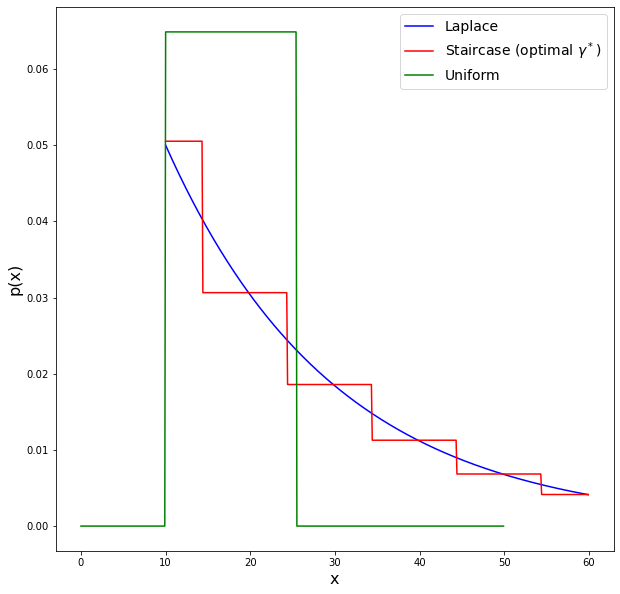

In [3]:
fig, ax = plt.subplots(figsize=(10,10))

batched=True
g = 10
eps = 1.
K = eps_to_K(eps)
xs = np.arange(0, 50, 0.1)
# ax.plot(xs, [pdf_staircase(eps/2., g, x, gamma=0) for x in xs], label=r'staircase ($\gamma =0$)')
a = g if batched else 0

ax.plot(a + xs, [pdf_exp(eps/2., g, x) for x in xs], label='Laplace', color='blue')
ax.plot(a + xs, [pdf_staircase(eps/2., g, x) for x in xs], label='Staircase (optimal $\gamma^*$)', color='red')
ax.plot(xs, [pdf_unif(K, g, x, batched) for x in xs], label='Uniform', color='green')

ax.legend(fontsize=14)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('p(x)', fontsize=16)
ax.set_xticks(np.arange(0, max(xs)+a+1, g))

plt.show()

In [4]:
def expected_delay_geom(g, eps):
    p = 1. - np.exp(-1*eps/(2*g))
    return g + ((1. - p) / p)

# gamma = OPT
def expected_delay_staircase(g, eps):
    return  g*(np.exp(eps/4.) / (np.exp(eps/2.) - 1)) + g

def expected_delay_laplace(g, eps):
    return 2*g/eps + g

def expected_delay_unif(g, K):
    return g + ((K + 1) / 2.)*g

In [5]:
def plot_delays(g, K_max=10, eps_max=6., ax=None, batched=True):
    if ax == None:
        fig, ax = plt.subplots(figsize=(10,10))
    
    eps_range = np.arange(K_to_eps(K_max), eps_max + 0.1, 0.1)
    
    expected_delays_lapl = [expected_delay_laplace(g, eps) / g for eps in eps_range]
    expected_delays_staircase = [expected_delay_staircase(g, eps) / g for eps in eps_range]
    expected_delays_unif = [expected_delay_unif(g, eps_to_K(eps)) / g for eps in eps_range]
    
    ax.plot(eps_range, expected_delays_lapl, label='Laplace DP Random Delay', color='blue')
    ax.plot(eps_range, expected_delays_staircase, label='Staircase DP Random Delay', color='orange')
    ax.plot(eps_range, expected_delays_unif, label='Randomized Epoch', color='green') # 'ro-'
            
    ax.set_xlabel(r'$\epsilon$', fontsize=14)
    ax.set_ylabel(r'Expected Delay of Batched Comments (as a multiple of $g$)', fontsize=14)
    ax.set_yticks(np.arange(1,12,1))
    
    ax.legend(fontsize=14)

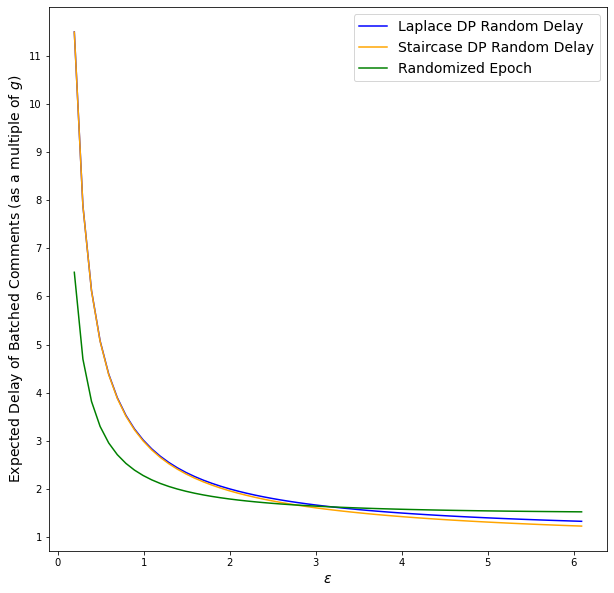

In [6]:
plot_delays(10)

In [7]:
def plot_lapl_staircase_ratio(g, eps_max=10., ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(10,10))
    
    eps_range = np.arange(0.001, eps_max + 0.1, 0.1)
    
    expected_delays_lapl = [expected_delay_laplace(g, eps) / g for eps in eps_range]
    expected_delays_staircase = [expected_delay_staircase(g, eps) / g for eps in eps_range]
    
    ratio = [(b-1) / (a-1) for a,b in zip(expected_delays_staircase, expected_delays_lapl)]
    
    ax.plot(eps_range, ratio)
    ax.set_title('Ratio of Laplace Noise Amplitude to Staircase Noise Amplitude', fontsize=16)
    ax.set_xlabel(r'$\epsilon$', fontsize=16)
    ax.set_ylabel("$|X_{Laplace}| / |X_{Staircase}|$", fontsize=14)

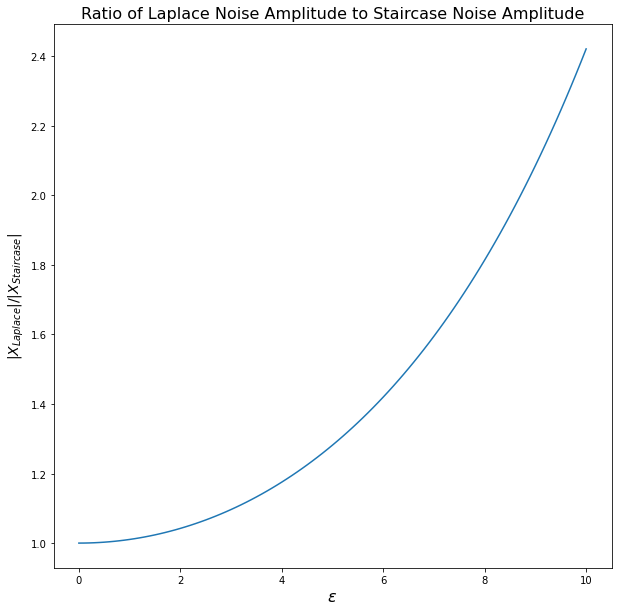

In [8]:
plot_lapl_staircase_ratio(1)

In [9]:
from scipy.stats import geom, uniform, bernoulli

def sample_staircase(eps, g, gamma=None, size=1):
    # if gamma = None, use OPT
    if gamma is None:
        gamma = 1/(1+np.exp(eps/2.))
    b = np.exp(-1.*eps)
    G = geom.rvs(1-b, loc=-1, size=size)
    U = uniform.rvs(size=size)
    p0 = gamma / (gamma + ((1-gamma)*b))
    B = bernoulli.rvs(1.-p0, size=size)
    return (1-B)*((G + gamma*U)*g) + B*((G + gamma + ((1-gamma)*U))*g)

## Truncated Exponential Noise

In [10]:
def get_K(eps, gamma):
    assert(gamma < eps)
    return np.log((np.exp(gamma + eps)  - np.exp(gamma)) / (np.exp(eps) - np.exp(gamma))) / gamma
#     return (1./gamma) * (np.log(np.exp(eps) - 1) - np.log(np.exp((eps - gamma)) - 1))

def expectation_trunc_exp(eps, gamma, batched):
    K = get_K(eps, gamma)
                              
    def get_exp(M, l):
        return (1./l) * (1. - (((M * l) + 1) * np.exp(-M * l))) / (1. - np.exp(-M * l))
    
    if batched:
        return 1. + get_exp(K - 1, gamma)
    else:
        return get_exp((K), gamma)
                              
def expectation_unif(eps, batched, p = 1.):
    if batched:
        return 0.5*(1 + (p / ((p - np.exp(-1*eps)))))
    else:
        return (p**2 / (2*(p-np.exp(-1*eps))))

def expectation_staircase(eps, batched):
    e = (np.exp(eps / 2) / (np.exp(eps) - 1))
    if batched:
        return 1 + e
    else:
        return e

def expectation_exp(eps, batched):
    if batched:                     
        return 1. + (1. / eps)
    else:
        return 1. / eps

In [11]:
def plot_expectations(eps, batched=False, ax=None):
    
    no_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
        no_ax = True

    gammas = np.arange(eps/1000., eps - 0.00001, eps/1000.)
    trunc = [expectation_trunc_exp(eps, gamma, batched) for gamma in gammas]
    ax.plot(gammas, trunc,
            label='truncated exponential', lw=3.)
    unif = expectation_unif(eps, batched)
    ax.hlines(unif, xmin=eps/1000., xmax=eps,
              label='uniform', color='green', ls='dashed', lw=3.)
    exp = expectation_exp(eps, batched)
    ax.hlines(exp, xmin=eps/1000., xmax=eps,
              label='exponential (untruncated)', color='red', ls='dotted', lw=3.)
        
    if no_ax:
        if exp <= unif and exp <= min(trunc):
            print('Expectation minimized by Exponential.')
        elif unif <= min(trunc):
            print('Expectation minimized by Uniform.')
        else:
            print(f'Expectation minimized by Truncated Exponential with gamma={gammas[np.argmin(trunc)]}')

        ax.legend(fontsize=16, loc='best')
        
    ax.set_title(r'$\epsilon=$'+f'{eps}', fontsize=26)
    ax.set_ylabel('expected delay', fontsize=22)
    ax.set_xlabel(r'$\gamma$', fontsize=22)
    
    ax.tick_params(axis='both', which='major', labelsize=16)

Expectation minimized by Truncated Exponential with gamma=0.0044


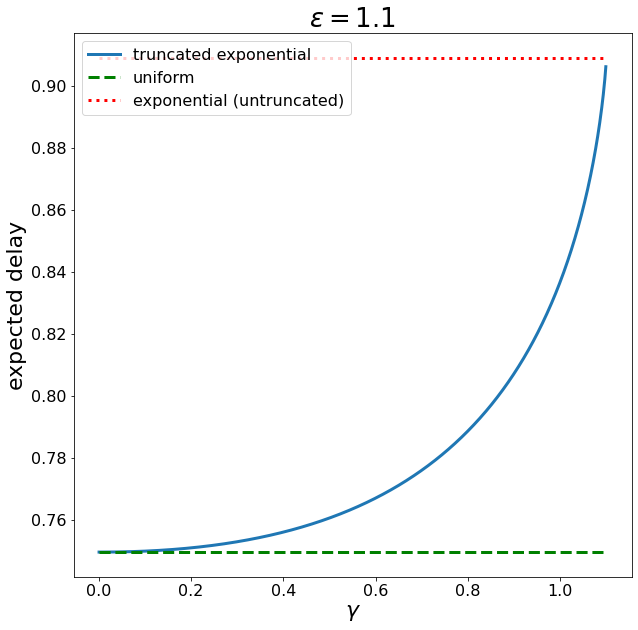

In [12]:
plot_expectations(1.1, batched=False)

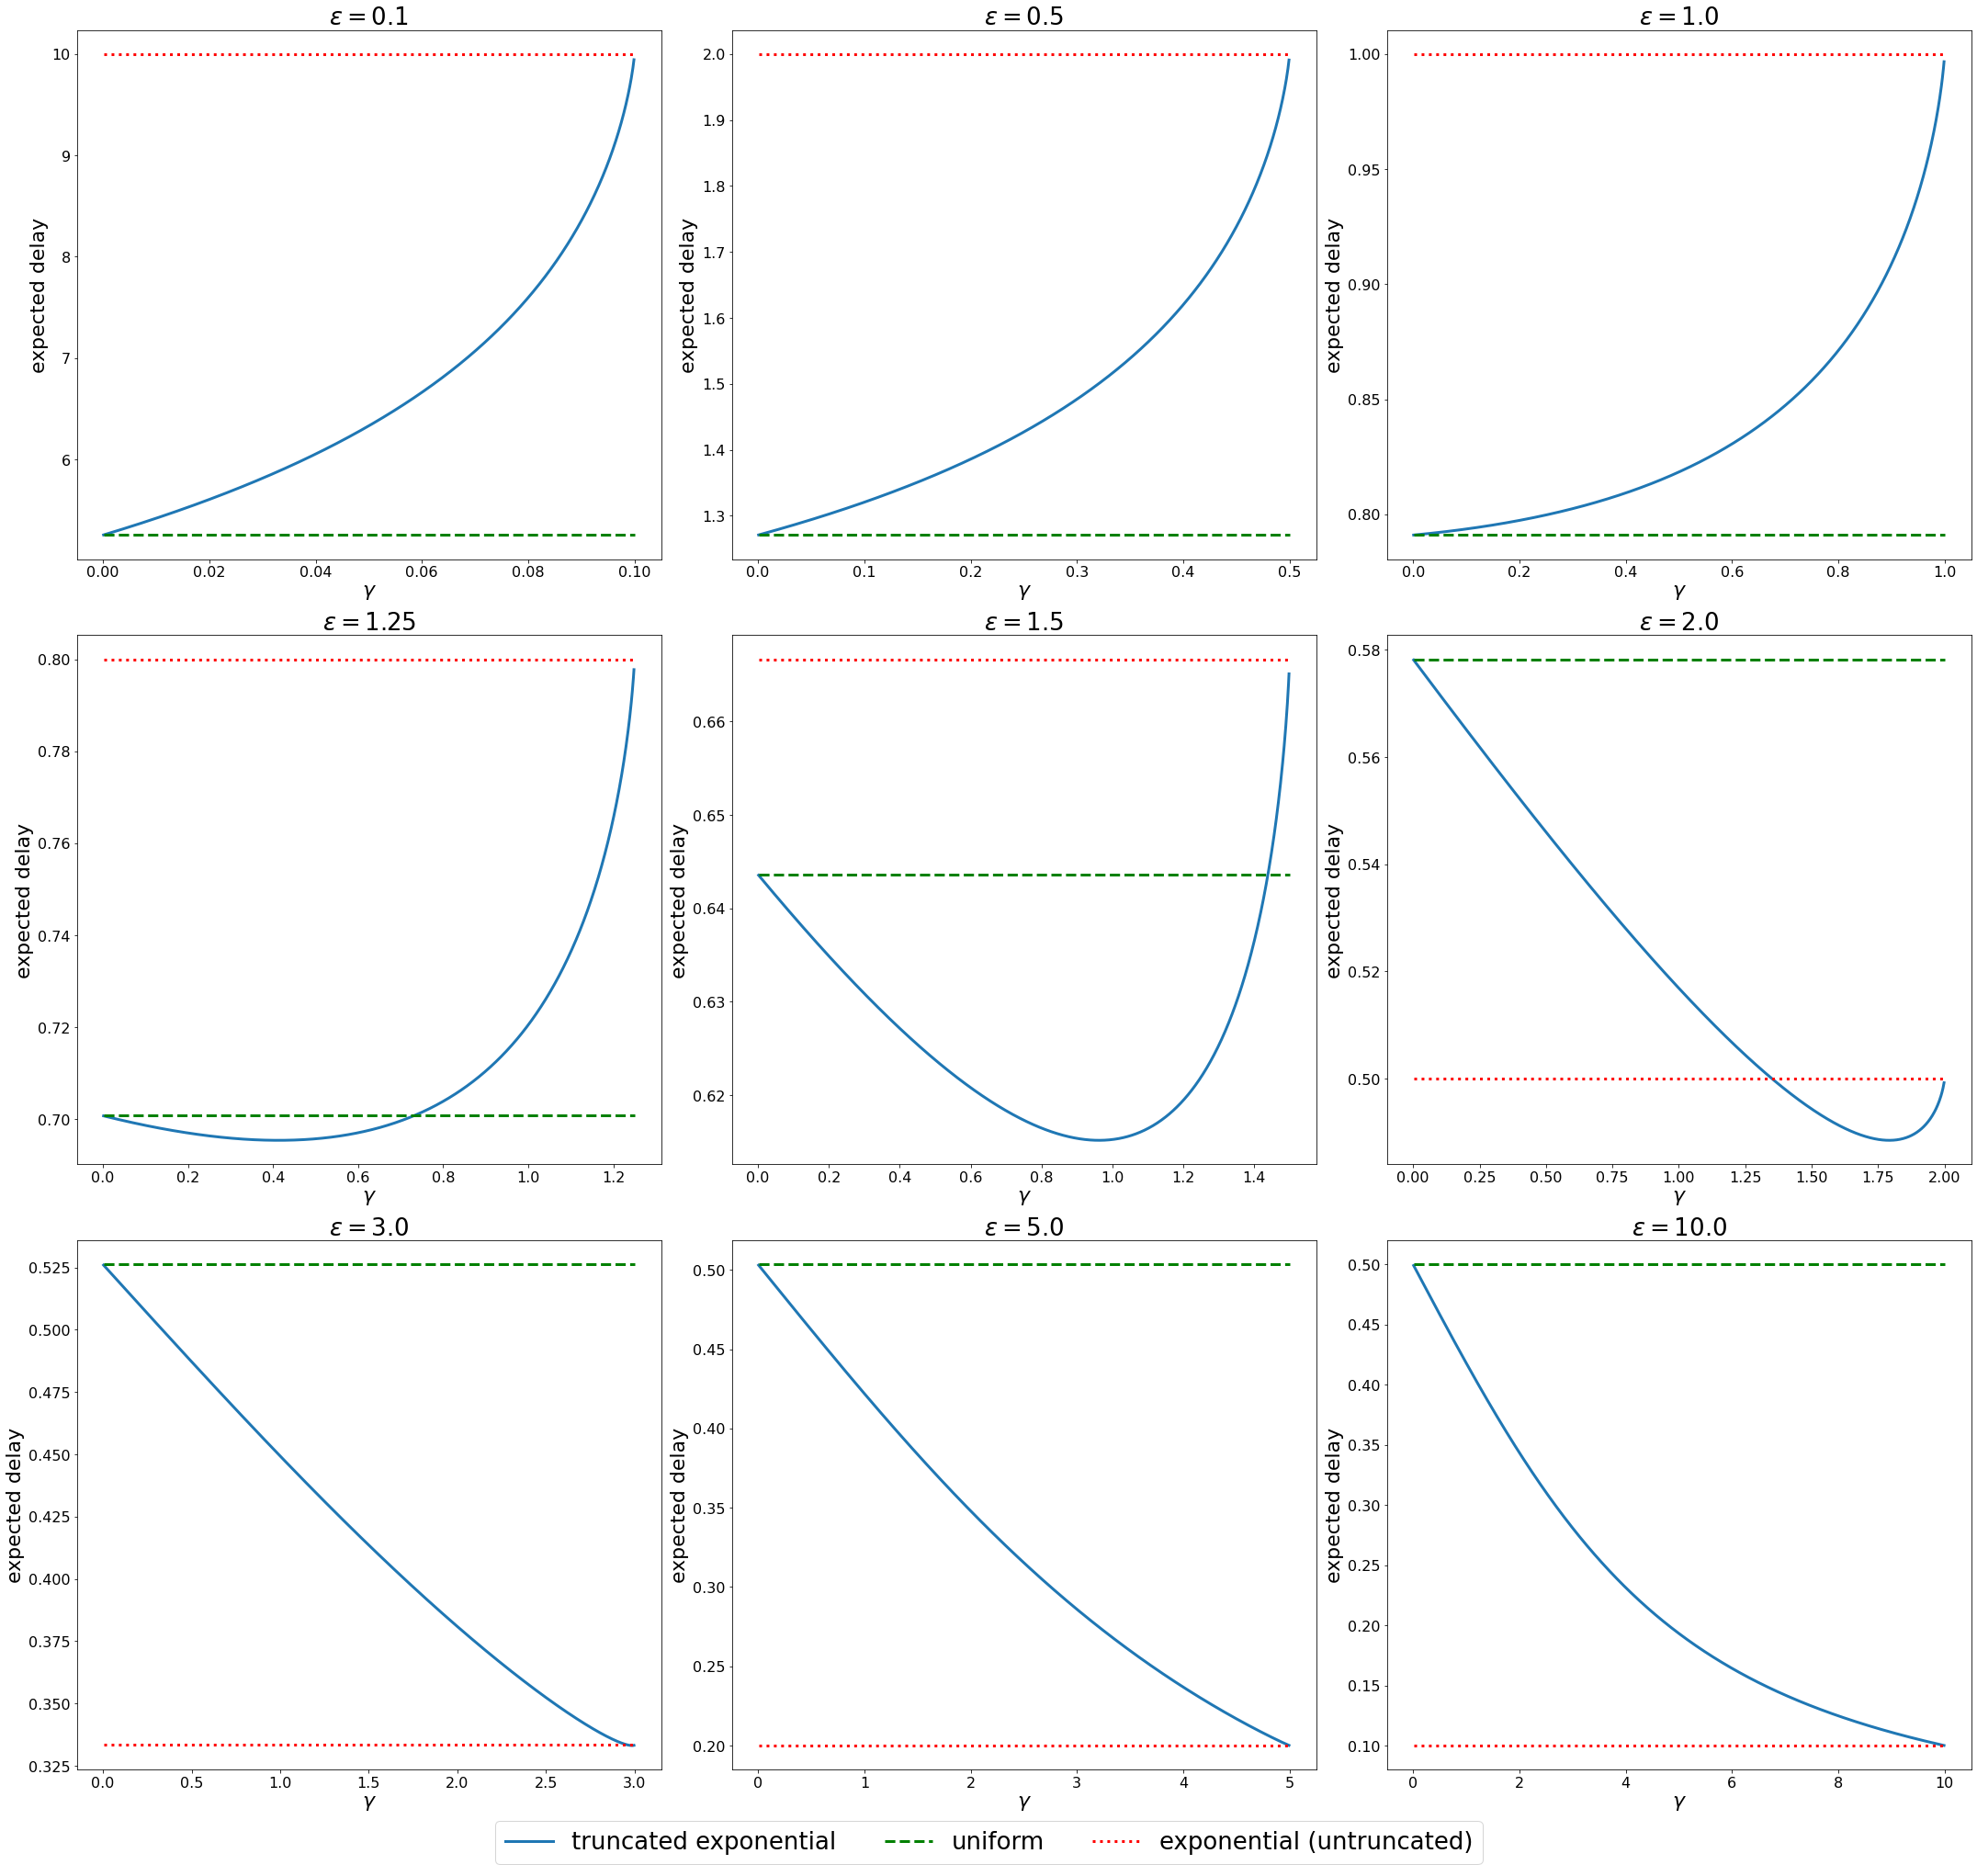

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(30,30))

eps = [0.1, 0.5, 1., 1.25, 1.5,  2., 3., 5., 10.]

for i, ax in enumerate(axes.ravel()):
    plot_expectations(eps[i], ax=ax)

# fig.suptitle('Expected Value of U', fontsize=28, y=0.92)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=26, ncol=len(labels))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

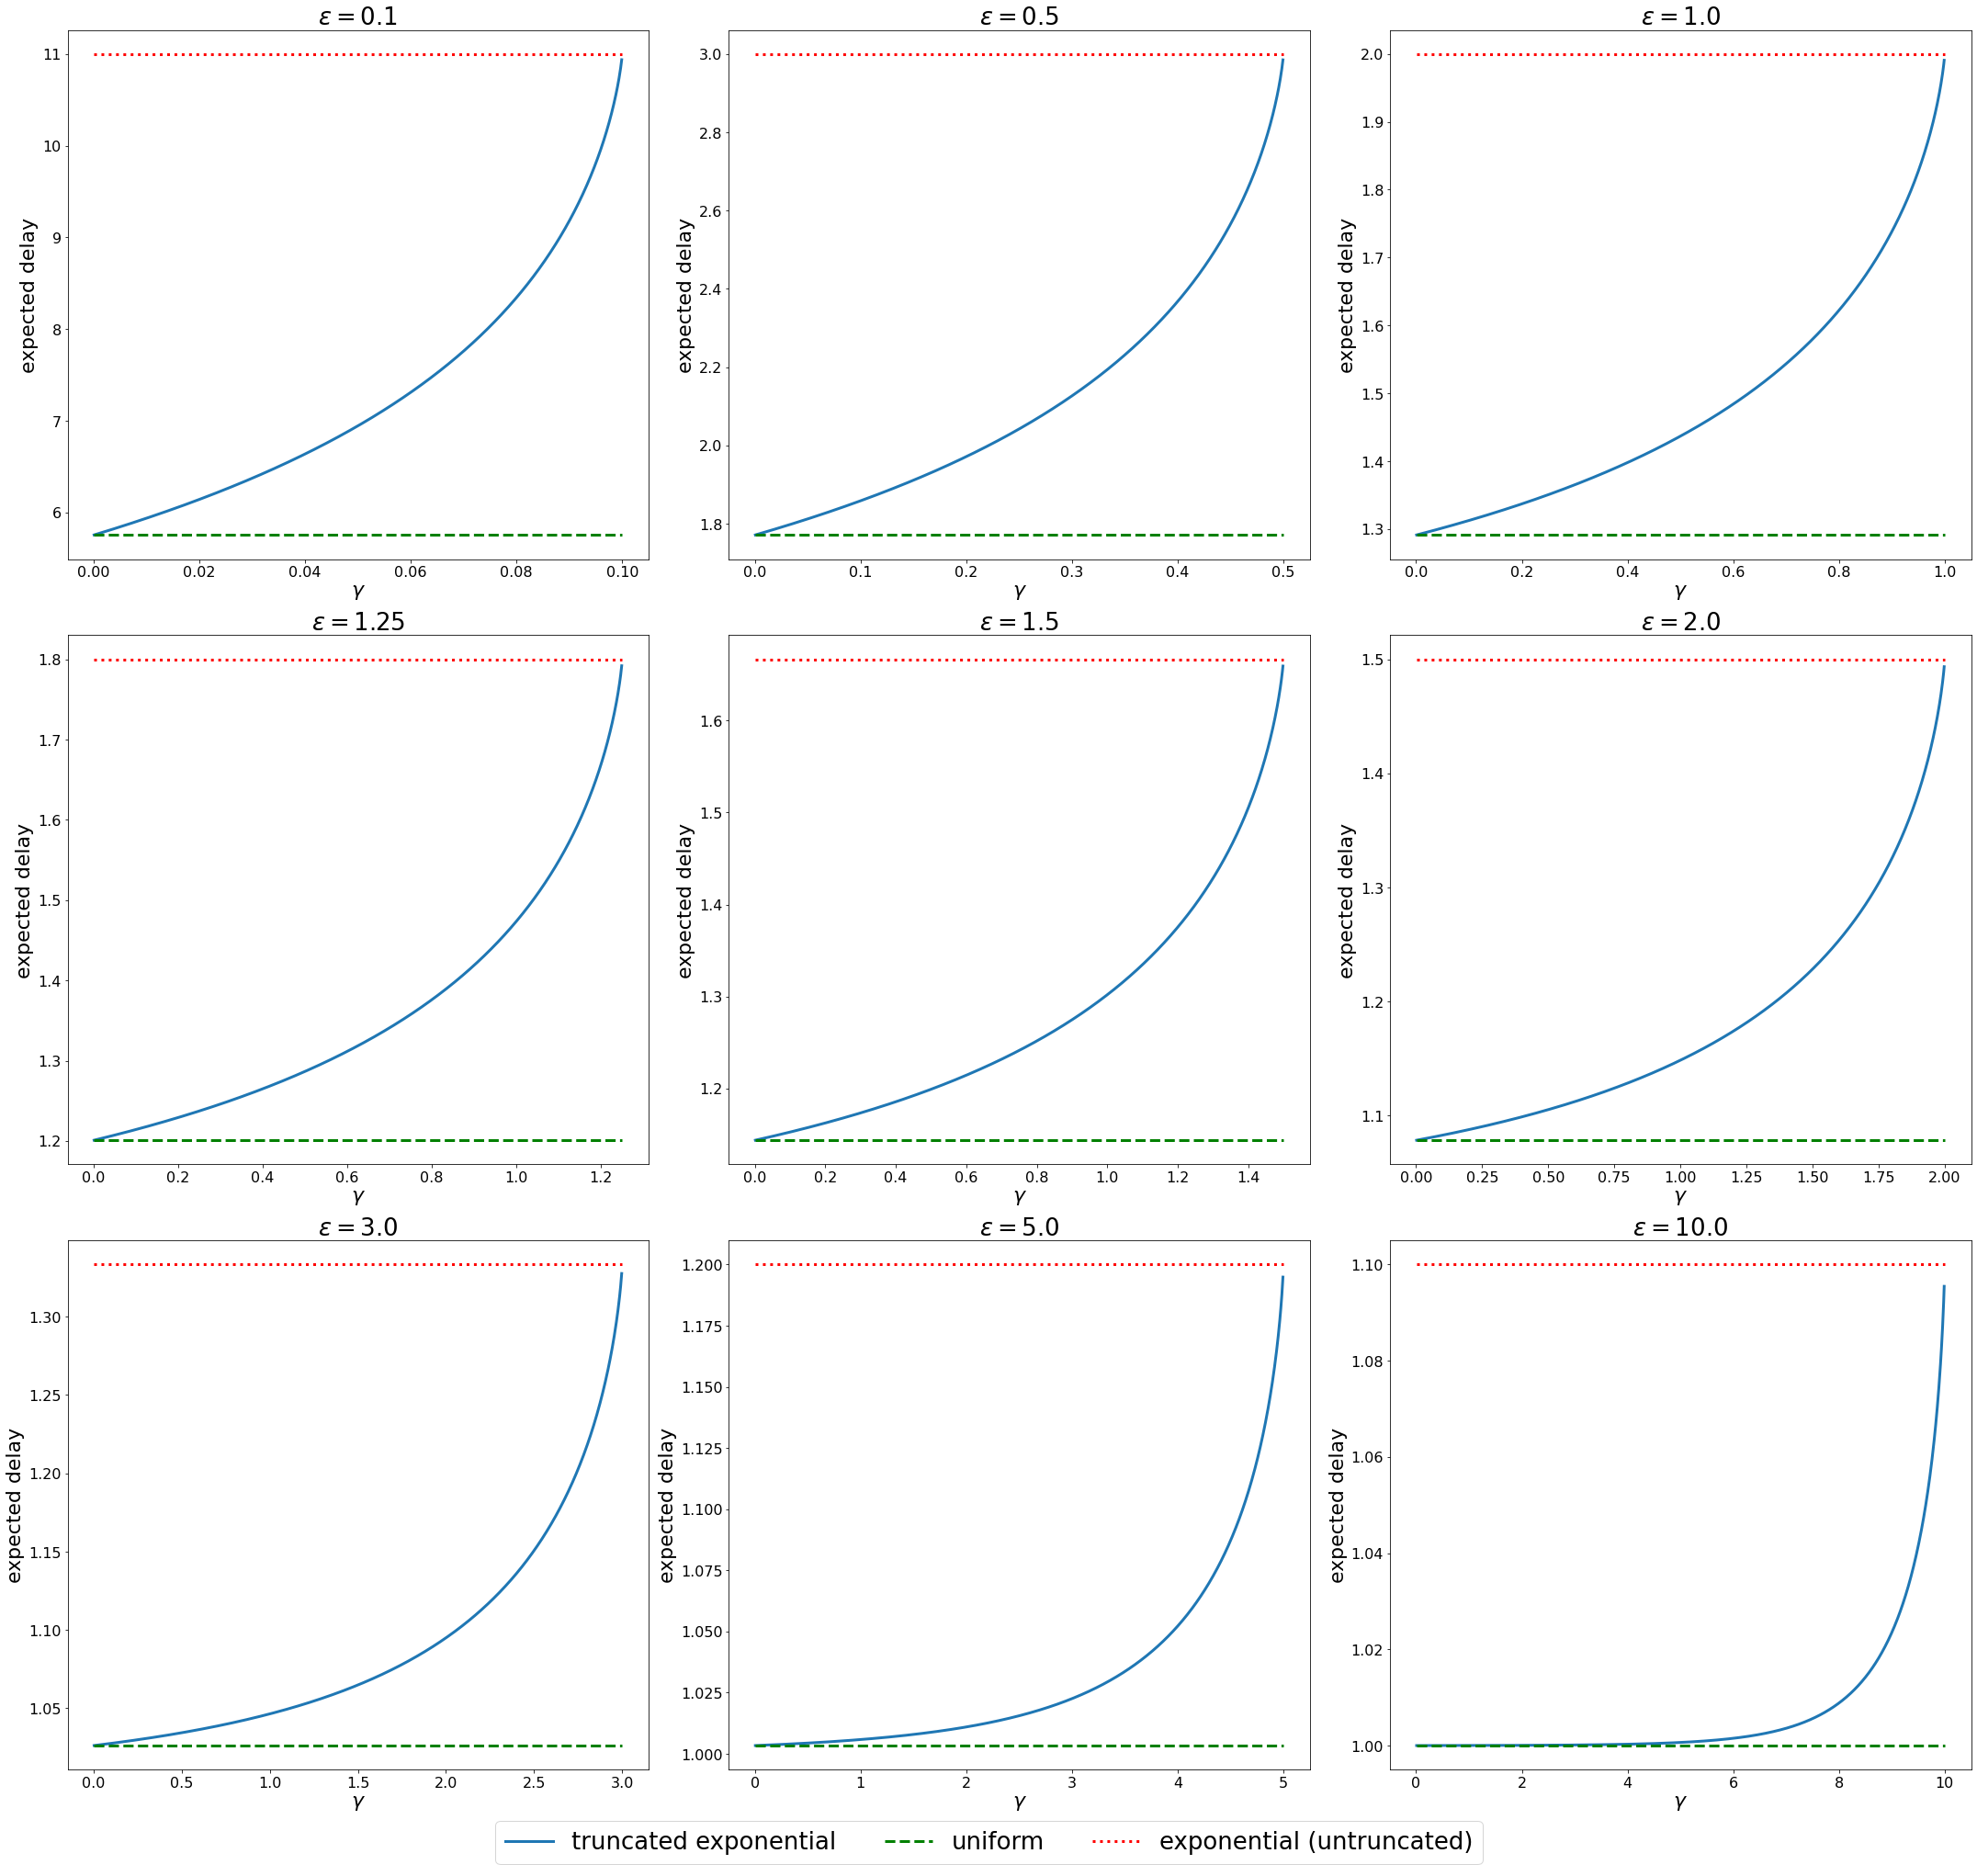

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(30,30))

for i, ax in enumerate(axes.ravel()):
    plot_expectations(eps[i], batched=True, ax=ax)

# fig.suptitle('Expected Value of B', fontsize=24, y=0.92)
fig.legend(handles, labels, loc='lower center', fontsize=26, ncol=len(labels))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

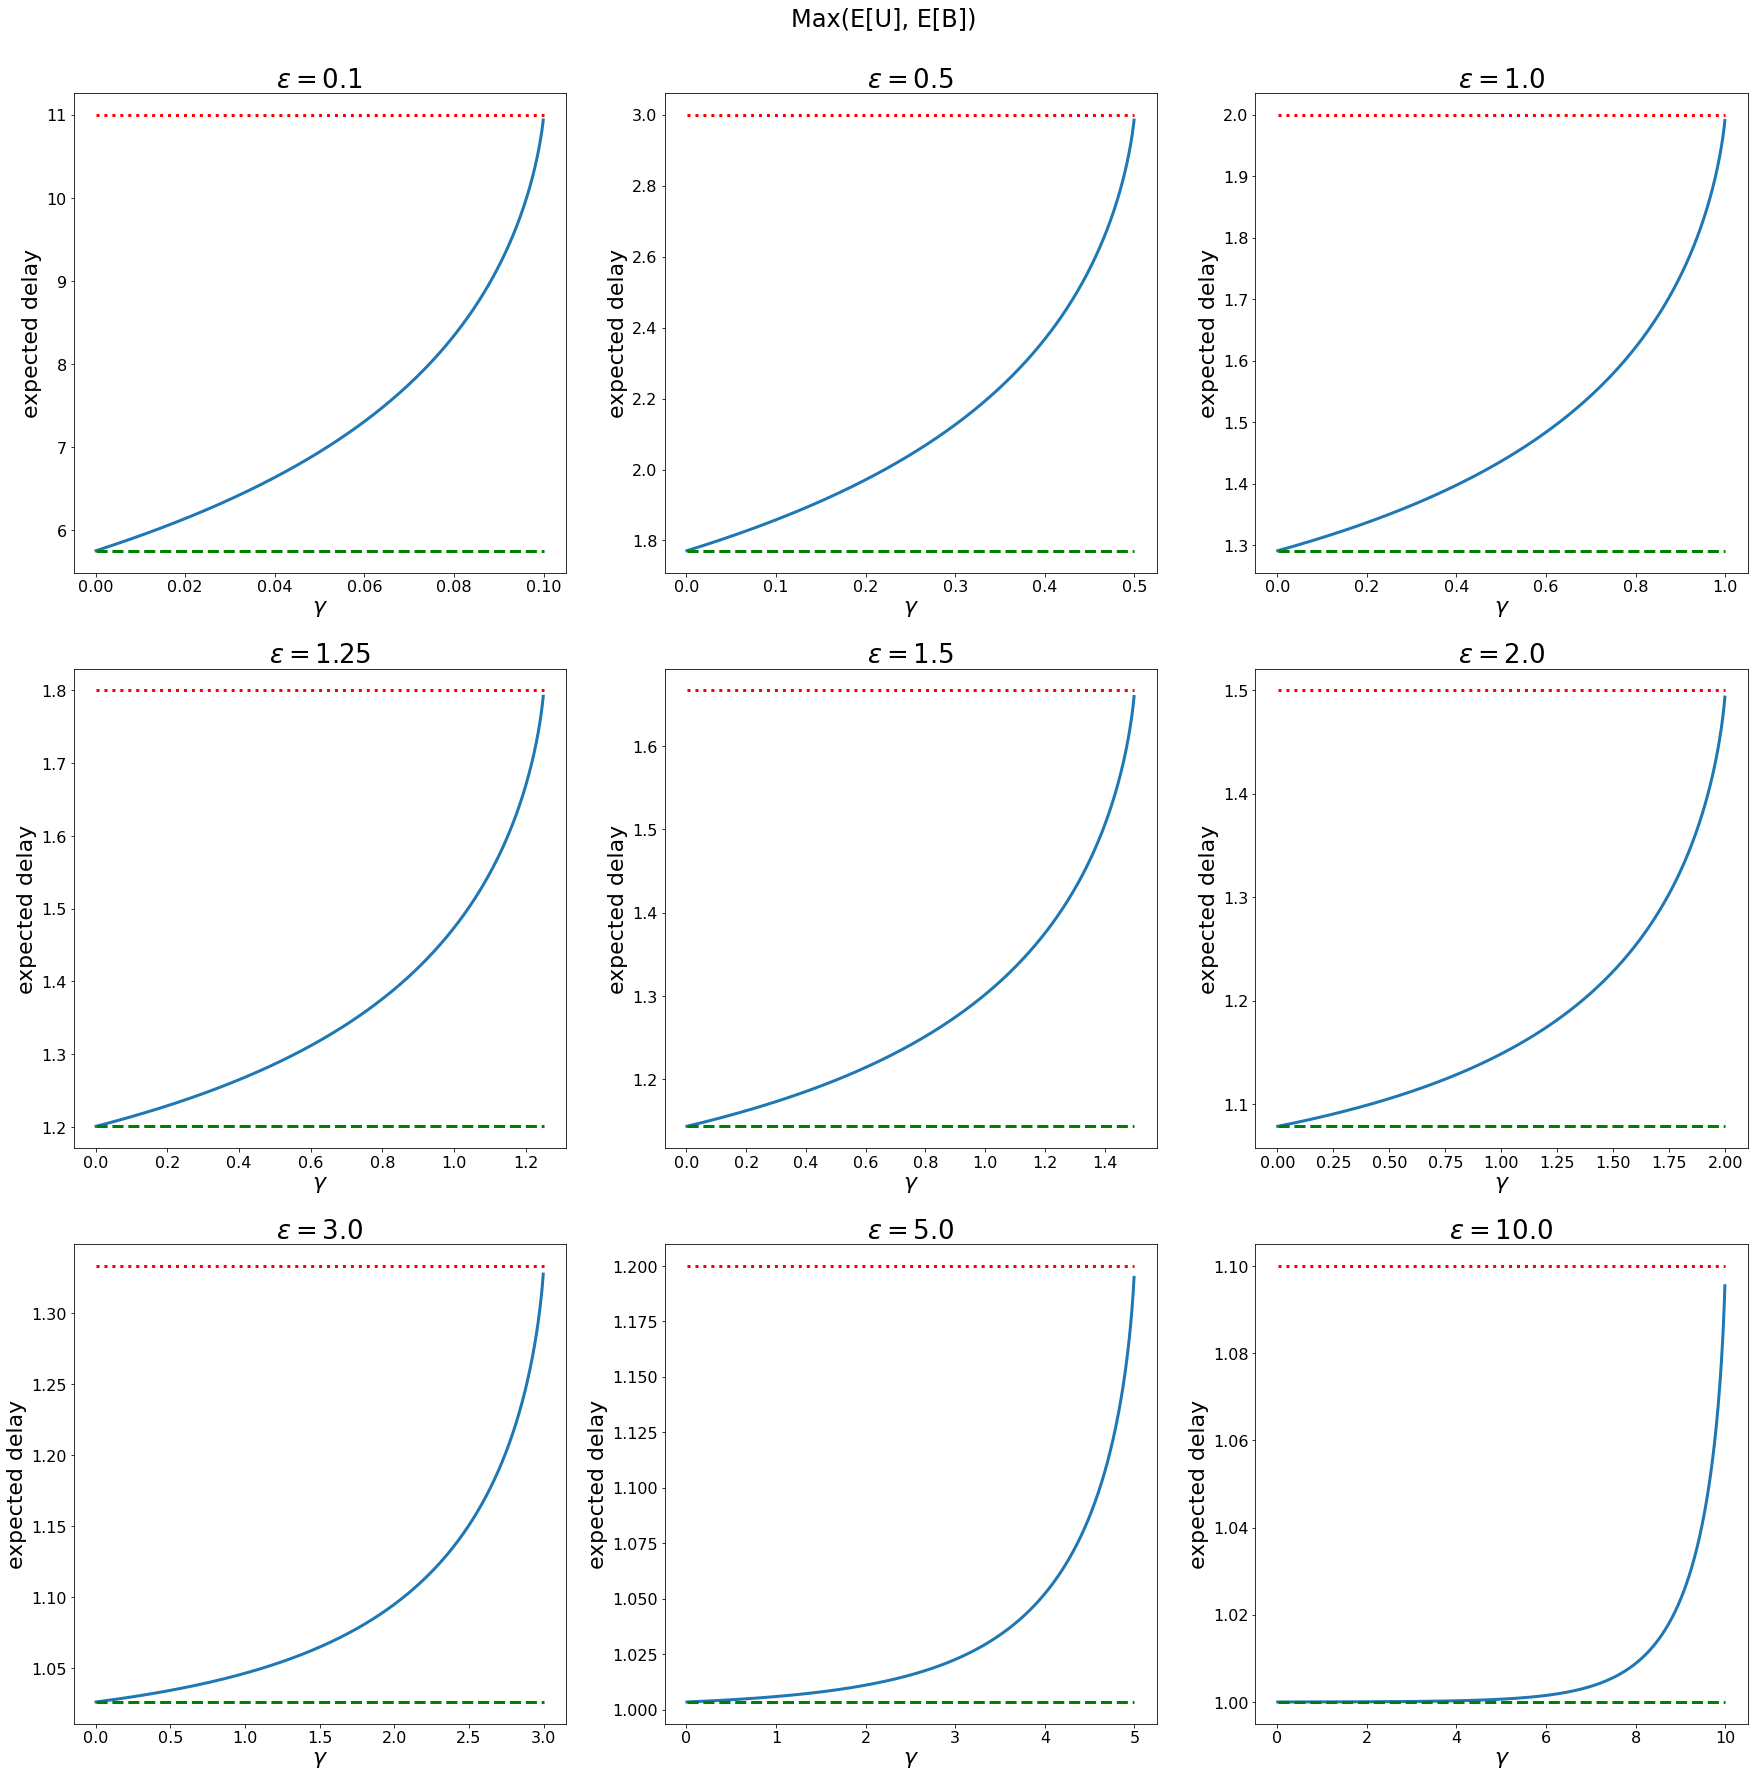

In [15]:
def plot_max_expectations(eps, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))

    gammas = np.arange(eps/1000., eps - 0.00001, eps/1000.)
    ax.plot(gammas, [max(expectation_trunc_exp(eps, gamma, True), expectation_trunc_exp(eps, gamma, False))
                     for gamma in gammas],
            label='truncated exponential')
    ax.hlines(max(expectation_unif(eps, True), expectation_unif(eps, False)), xmin=eps/1000., xmax=eps,
              label='uniform', color='grey', ls='dashed')
    ax.hlines(max(expectation_exp(eps, True), expectation_exp(eps, False)), xmin=eps/1000., xmax=eps,
              label='exponential (untruncated)', color='black', ls='dotted')
    
    ax.legend() # loc='center left'
    ax.set_title(r'$\epsilon=$'+f'{eps}', fontsize=20)
    ax.set_ylabel('expected delay', fontsize=16)
    ax.set_xlabel(r'$\gamma$', fontsize=16)

fig, axes = plt.subplots(3, 3, figsize=(30,30))

for i, ax in enumerate(axes.ravel()):
    plot_expectations(eps[i], batched=True, ax=ax)

fig.suptitle('Max(E[U], E[B])', fontsize=24, y=0.92)

plt.show()

In [65]:
g = 1.
eps = np.arange(0.1, 3, 0.1)

In [66]:
def get_opt_p(eps, batched=False):
    if batched:
        return 1
    else:
        return min(2*np.exp(-eps), 1)

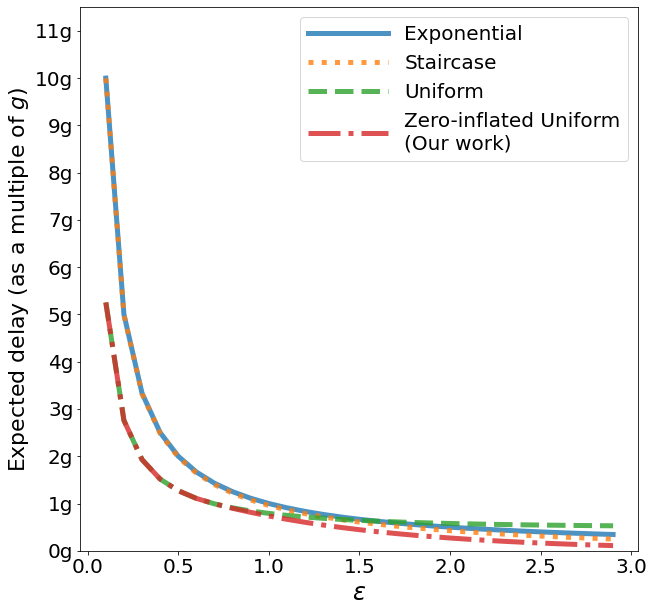

In [72]:
## UNBATCHED
fig, axes = plt.subplots(1, 1, figsize=(10,10))
e_lap = [expectation_exp(e, batched=False) for e in eps]
plt.plot(eps, e_lap, label = 'Exponential', lw=5, ls='-', alpha=0.8)
plt.plot(eps, [expectation_staircase(e, batched=False) for e in eps],
         label = 'Staircase', lw=5, ls='dotted', alpha=0.8)
plt.plot(eps, [expectation_unif(e, False, p=get_opt_p(e, True)) for e in eps],
         label = 'Uniform', lw=5, ls='--', alpha=0.8)
plt.plot(eps, [expectation_unif(e, False, p=get_opt_p(e, False)) for e in eps],
         label = 'Zero-inflated Uniform\n(Our work)', lw=5, ls='-.', alpha=0.8)



plt.legend(fontsize=20, handlelength=4)

plt.ylabel(r'Expected delay (as a multiple of $g$)', fontsize=22)
ys = np.arange(0, max(e_lap)+2, 1)
plt.ylim(0, max(ys)+0.5)
plt.yticks(ys, labels=[f'{int(t)}g' for t in ys], fontsize=20)
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.xticks(np.arange(0, max(eps)+0.5, 0.5), fontsize=20)
plt.show()

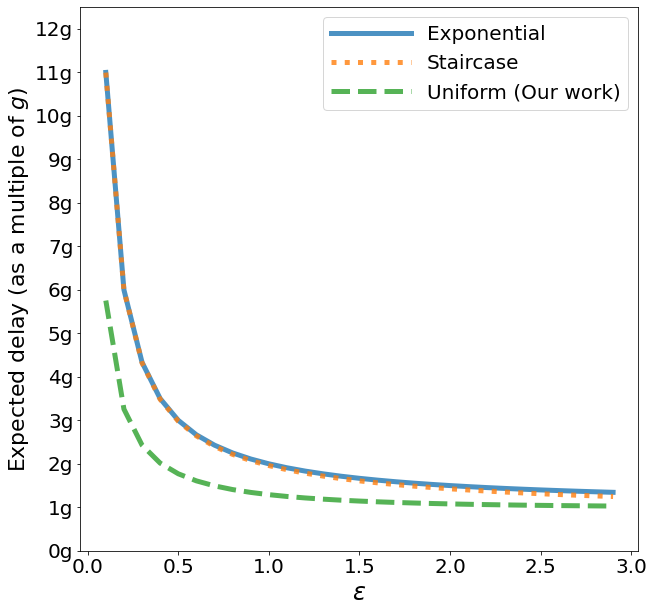

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(10,10))
e_lap = [expectation_exp(e, batched=True) for e in eps]
plt.plot(eps, e_lap, label = 'Exponential', lw=5, ls='-', alpha=0.8)
plt.plot(eps, [expectation_staircase(e, batched=True) for e in eps],
         label = 'Staircase', lw=5, ls='dotted', alpha=0.8)
plt.plot(eps, [expectation_unif(e, True, p=get_opt_p(e, True)) for e in eps],
         label = 'Uniform (Our work)', lw=5, ls='--', alpha=0.8)

plt.legend(fontsize=20, handlelength=4)

plt.ylabel(r'Expected delay (as a multiple of $g$)', fontsize=22)
ys = np.arange(0, max(e_lap)+2, 1)
plt.ylim(0, max(ys)+0.5)
plt.yticks(ys, labels=[f'{int(t)}g' for t in ys], fontsize=20)
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.xticks(np.arange(0, max(eps)+0.5, 0.5), fontsize=20)
plt.show()

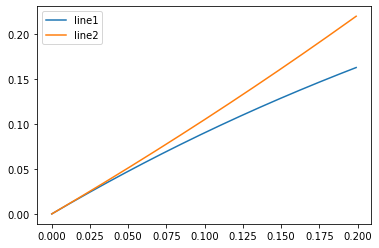

In [296]:
eps = np.arange(0.0001, 0.2, 0.001)

plt.plot(eps, [e * np.exp(-1 * e) for e in eps], label = 'line1')
plt.plot(eps, [np.exp(e) - 1 for e in eps], label= 'line2')

plt.legend()

In [297]:
def pdf_truncated_exp(x, eps, gamma, g=1, batched=False):
    K = g * get_K(eps, gamma)
    if batched == True:
        K = K-1
    l = gamma / g
    if x >= 0 and x <= K*g:
        return l * np.exp(-l * x) / (1. - np.exp(-1*K * l))
    else:
        return 0

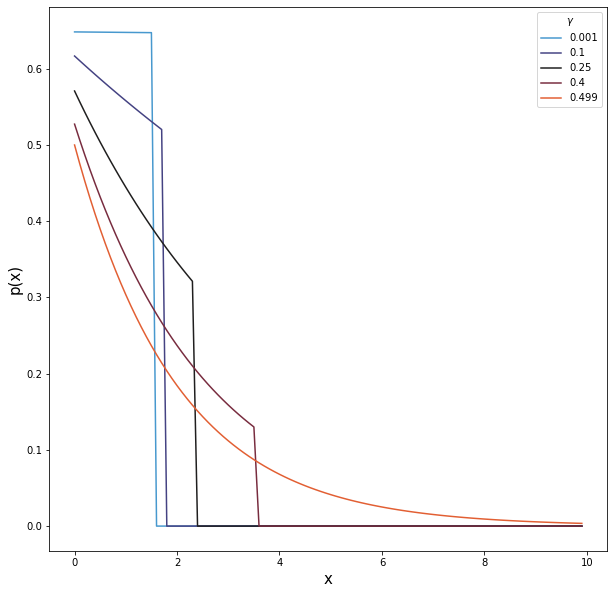

In [172]:
eps = 0.5
g = 1
gammas = [0.001, 0.1, 0.25, 0.4, 0.499]

fig, ax = plt.subplots(figsize=(10,10))
colors = sns.color_palette("icefire", n_colors=len(gammas))

xs = np.arange(0.001, 10, 0.1)
for i,gamma in enumerate(gammas):
    plt.plot(xs, [pdf_truncated_exp(x, eps, gamma, g, batched=True) for x in xs], label=f'{gamma}', color=colors[i])

# plt.plot(xs, [(1.-np.exp(-1. * eps))/(g*np.exp(-1*eps)) if x <= g/(1-np.exp(-eps)) else 0 for x in xs], color='grey')
    
plt.legend(title=r'$\gamma$')
plt.xlabel('x', fontsize=15)
plt.ylabel('p(x)', fontsize=15)
plt.show()

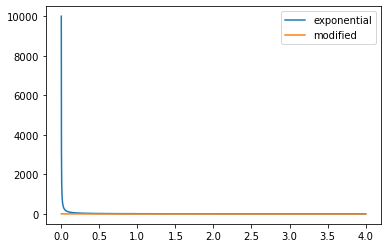

In [175]:
g = 10
eps_values = np.arange(0.001, 4, 0.0001)
plt.plot(eps_values, [g/eps for eps in eps_values], label ='exponential')
plt.plot(eps_values, [(1+eps)*np.exp(-eps*(g+1)) for eps in eps_values], label='modified')

plt.legend()

plt.show()

## Pareto Frontier Plots

In [22]:
def exp_U_opt(eps, p):
    return 0.5 * p**2 / (p - np.exp(-eps))
    
def exp_B_opt(eps, p):
    return 0.5 * (1 + (p/(p - np.exp(-eps))))

def get_pareto(eps, w_U, w_B):
    p = 1       
    if w_U > 0:
        M = 1 + np.sqrt(1 + np.exp(eps)*(w_B / w_U))
        if np.exp(eps) > M:
            p = M*np.exp(-eps)
    return p, exp_U_opt(eps, p), exp_B_opt(eps, p)

In [23]:
expectation_unif(3., True, p=0.5)

1.0552928013277776

In [24]:
get_pareto(3., 1, 0)

(0.09957413673572789, 0.09957413673572789, 1.5)

In [82]:
w_Us = np.arange(0, 1.1, 0.1)
ws = list(zip(w_Us, 1. - w_Us))
eps_list = [0.5, 0.75, 1., 2., 3.]

pareto_frontier = {e: [get_pareto(e/2, w_U, w_B) for w_U, w_B in ws] for e in eps_list}

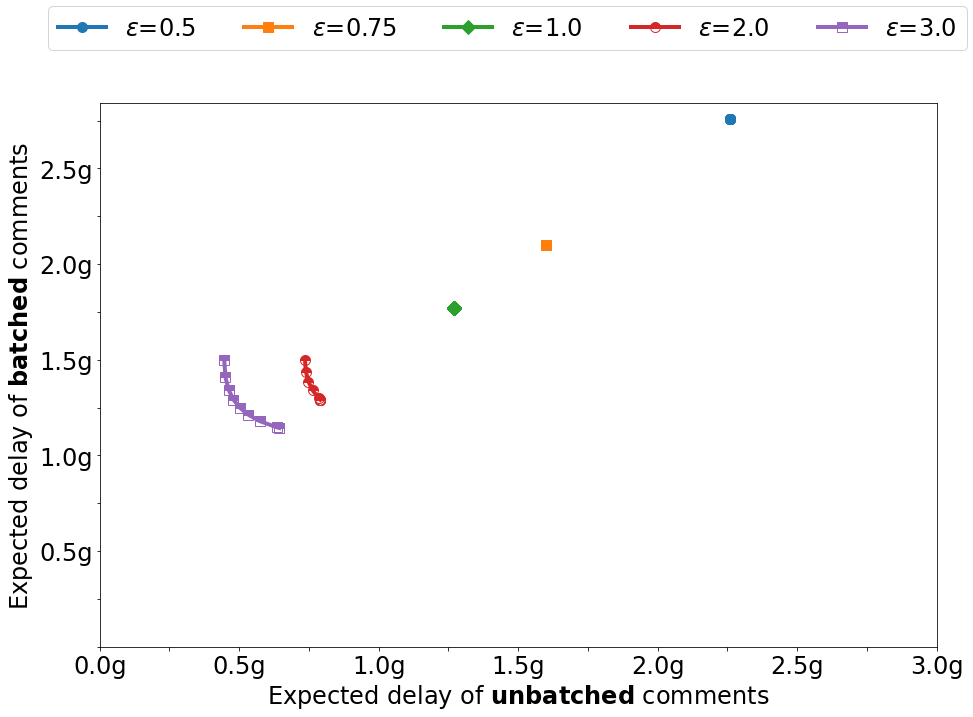

In [104]:
fig, ax = plt.subplots(figsize=(15,10))

markers = itertools.cycle(('o', 's', 'D')) 
for i,eps in enumerate(eps_list):
    Us = list(zip(*pareto_frontier[eps]))[1]
    Bs = list(zip(*pareto_frontier[eps]))[2]
    fs = 'full' if i < 3 else 'top'
    plt.plot(Us, Bs, label=r'$\epsilon$=' + f'{eps}', lw=4, marker=next(markers),markersize=10, fillstyle=fs)

plt.xlabel(r'Expected delay of $\bf{unbatched}$ comments', fontsize=24)
plt.ylabel(r'Expected delay of $\bf{batched}$ comments', fontsize=24)
ys = np.arange(0, pareto_frontier[eps_list[0]][0][1]+0.5, 0.25)
plt.yticks(ys, labels=[f'{round(t,2)}g' for t in ys], fontsize=24)
xs = np.arange(0, pareto_frontier[eps_list[0]][0][2]+0.25, 0.25)
plt.xticks(xs, labels=[f'{round(t, 2)}g' for t in xs], fontsize=24)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
for i in range(len(xs)):
    if i%2 == 1:
        ax.xaxis.get_major_ticks()[i].label1.set_visible(False)
for i in range(len(ys)):
    if i%2 == 1:
        ax.yaxis.get_major_ticks()[i].label1.set_visible(False)
legend = plt.legend(fontsize=24, ncol=5, bbox_to_anchor=(1.05,1.2))

plt.setp(legend.get_title(),fontsize=22)
plt.show()

In [364]:
def pdf_laplace(eps, g, x):
    b = g / eps
    return (1./(b))*np.exp(-1.*np.abs(x)/b)

def pdf_staircase(eps, g, x, i = 6):
    k = np.floor(x*i/g)
#     print(k)
    b = g / eps
    return (i/g) * (np.exp(-k*(g/i)/b) - np.exp(-(k+1)*(g/i)/b)) 

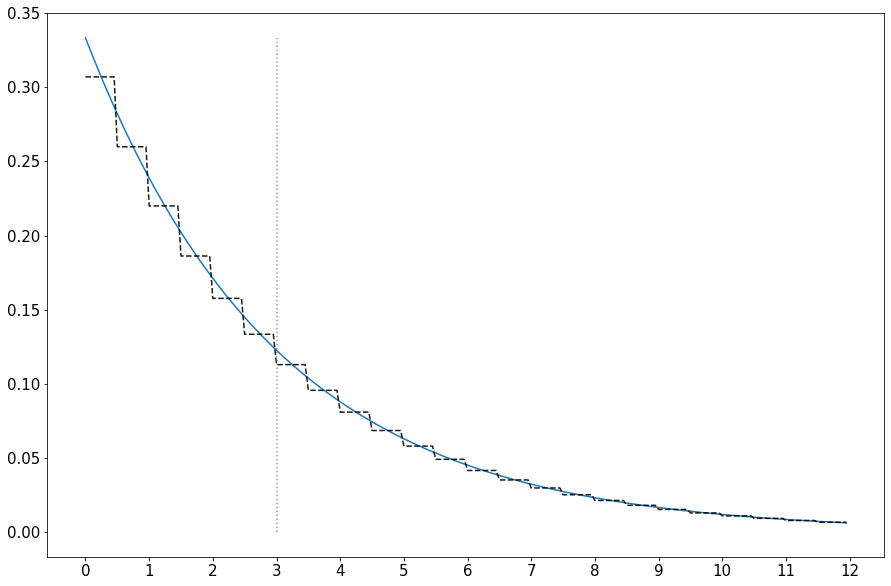

In [380]:
g = 3
eps = 1
xs = np.arange(0,12, 0.05)

fig, ax = plt.subplots(figsize=(15,10))

plt.plot(xs, [pdf_laplace(eps, g, x) for x in xs])
plt.plot(xs, [pdf_staircase(eps, g, x) for x in xs], color='black', ls='--', alpha=0.9)
plt.vlines(x=g, ymin=0, ymax=pdf_laplace(eps, g, 0), color='grey', linestyles='dotted', alpha=0.8)

plt.xticks(np.arange(0,13), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## K plots

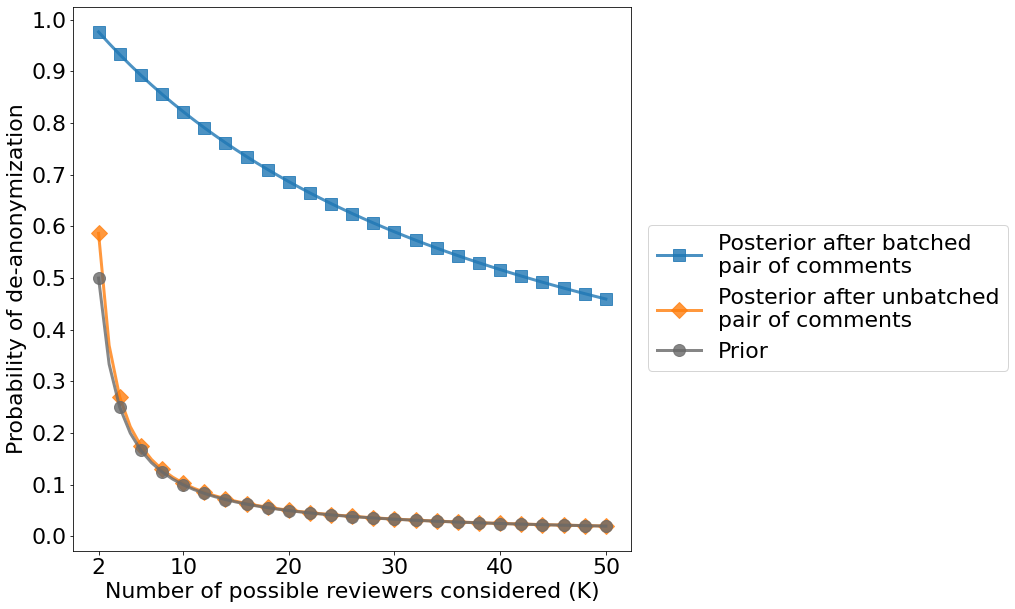

In [112]:
p_same = 0.3
p_diff = 0.0072

Ks = range(2,51)
pr = [1/K for K in Ks]
post_batch = [p_same / (p_same + (K-1)*p_diff) for K in Ks]
post_nobatch = [(1. - (1.-p_same) / ((1.-p_same) + (K-1)*(1.-p_diff))) / (K-1) for K in Ks]

fig, axes = plt.subplots(figsize=(10,10))

plt.plot(Ks, post_batch, marker='s', lw=3, label='Posterior after batched\npair of comments', alpha=0.8, 
         markersize=12, markevery=2)
plt.plot(Ks, post_nobatch, lw=3, marker='D', label='Posterior after unbatched\npair of comments', markersize=12,
        alpha=0.8, markevery=2)
plt.plot(Ks, pr, lw = 3, marker='o', linestyle='solid', color='dimgray', label=r'Prior', alpha=0.8,
         markersize=12, markevery=2)


plt.xticks([2] + list(np.arange(10,51, 10)), fontsize=22)
plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=22)

plt.legend(fontsize=22, bbox_to_anchor=(1.01, 0.62))

plt.xlabel('Number of possible reviewers considered (K)', fontsize=22)
plt.ylabel('Probability of de-anonymization', fontsize=22)

# plt.title('Peer review comments', fontsize=18)

plt.show()

In [113]:
Ks[8], post_batch[8], post_nobatch[8]

(10, 0.8223684210526315, 0.1030388575224178)

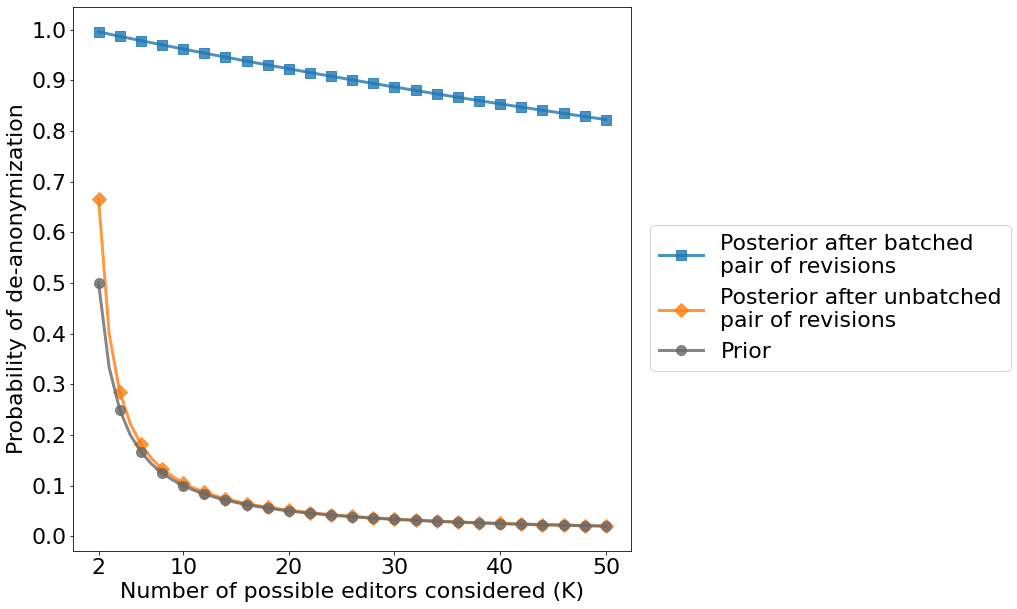

In [110]:
p_same = 0.5
p_diff = 0.0022

Ks = range(2,51)
pr = [1/K for K in Ks]
post_batch = [p_same / (p_same + (K-1)*p_diff) for K in Ks]
post_nobatch = [(1. - (1.-p_same) / ((1.-p_same) + (K-1)*(1.-p_diff))) / (K-1) for K in Ks]

fig, axes = plt.subplots(figsize=(10,10))

plt.plot(Ks, post_batch, marker='s', lw=3, label='Posterior after batched\npair of revisions', alpha=0.8, 
         markersize=10, markevery=2)
plt.plot(Ks, post_nobatch, lw=3, marker='D', label='Posterior after unbatched\npair of revisions', markersize=10,
        alpha=0.8, markevery=2)
plt.plot(Ks, pr, lw = 3, marker='o', linestyle='solid', color='dimgray', label=r'Prior', alpha=0.8,
         markersize=10, markevery=2)


plt.xticks([2] + list(np.arange(10,51, 10)), fontsize=22)
plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=22)

plt.legend(fontsize=22, bbox_to_anchor=(1.7, 0.62))

plt.xlabel('Number of possible editors considered (K)', fontsize=22)
plt.ylabel('Probability of de-anonymization', fontsize=22)

# plt.title('Peer review comments', fontsize=18)

plt.show()

In [111]:
Ks[8], post_batch[8], post_nobatch[8]

(10, 0.9619084263178145, 0.10525094407290986)